<div style="text-align: center; padding: 20px; border-radius: 15px; background: linear-gradient(135deg, #1a1a2e, #16213e); color: white; font-family: 'Segoe UI', sans-serif;">

  <span style="font-size: 2em; font-weight: bold;">Laboratorio 3</span>  
  <span style="color: #003D79; font-size: 1.5em;">Algoritmos Cuánticos</span>  

  <hr style="border: none; border-top: 1px solid #ddd; margin: 20px 0;">
  
  <span style="color: #D59F0F; font-size: 1.2em;">Universidad Nacional Autónoma de México</span>  
  <span style="color: #eb0b30; font-size: 1.5em;">Facultad de ingeniería</span>  

  <p style="font-size: 1em;">2958: Temas Selectos de Ingeniería en Computación III</p>
  <p style="font-weight: bold;">Computación Cuántica · 2025-2</p>

  <hr style="border: none; border-top: 1px solid #ddd; margin: 20px 0;">
  
  <span style="font-weight: bold;">López Ortega Diego</span>  
  <p style="font-style: italic;">Matrícula: 421058536</p>

</div>
 
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\mymatrix}[2]{\left[ \begin{array}{#1} #2\end{array} \right]} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $


# Ejercicio 1

## Función

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_vector, plot_histogram, plot_bloch_multivector

from qiskit.providers.basic_provider import BasicSimulator
import numpy as np
from numpy import pi, random
from IPython.display import display

def teleportacion(theta, phi, lam, bell_state='phi_plus'):
    # ----- Estado original ----- 
    circ_temp = QuantumCircuit(1)                                  # circuito con solo el estado a enviar
    circ_temp.u(theta, phi, lam, 0)                                # aplicar los ángulos aleatorios al único qubit
    
    psi_state = Statevector(circ_temp)                             # obtenemos el vector de estado para visualizarlo

    # -----  Esfera de Bloch ----- 
    display(psi_state.draw('latex', prefix="|\\psi\\rangle ="))    # mostrar en notación de Dirac
    display(plot_bloch_multivector(psi_state))                     # mostrar en esfera de Bloch

    
    # Crear registros cuánticos y clásicos
    qr_alicia = QuantumRegister(2, name='alicia')
    qr_bob = QuantumRegister(1, name='bob')
    crz = ClassicalRegister(1, name='crz')
    crx = ClassicalRegister(1, name='crx')
    bob_med = ClassicalRegister(1, name='bob_med')
    
    circuito = QuantumCircuit(qr_alicia, qr_bob, crz, crx, bob_med)

    # ----- Estado a teleportar -----
    circuito.u(theta, phi, lam, qr_alicia[0])
    circuito.barrier()


    # ----- Crear el par de Bell entre alicia[1] y bob[0] -----
    if bell_state == 'phi_plus':
        circuito.h(qr_alicia[1])
        circuito.cx(qr_alicia[1], qr_bob[0])
    elif bell_state == 'phi_minus':
        circuito.h(qr_alicia[1])
        circuito.cx(qr_alicia[1], qr_bob[0])
        circuito.z(qr_bob[0])
    elif bell_state == 'psi_plus':
        circuito.h(qr_alicia[1])
        circuito.cx(qr_alicia[1], qr_bob[0])
        circuito.x(qr_bob[0])
    elif bell_state == 'psi_minus':
        circuito.h(qr_alicia[1])
        circuito.cx(qr_alicia[1], qr_bob[0])
        circuito.x(qr_bob[0])
        circuito.z(qr_bob[0])
    else:
        raise ValueError("Estado de Bell no válido. Usa: 'phi_plus', 'phi_minus', 'psi_plus', 'psi_minus'")
    circuito.barrier()

    # ----- Operaciones de Alice -----
    circuito.cx(qr_alicia[0], qr_alicia[1])
    circuito.h(qr_alicia[0])
    circuito.barrier()

    # ----- Medición de Alice -----
    circuito.measure(qr_alicia[0], crz[0])
    circuito.measure(qr_alicia[1], crx[0])
    circuito.barrier()

    # ----- Correcciones de Bob -----
    circuito.x(qr_bob[0]).c_if(crx, 1)
    circuito.z(qr_bob[0]).c_if(crz, 1)

    if bell_state == 'psi_plus':
        circuito.x(qr_bob[0])
    elif bell_state == 'psi_minus':
        circuito.x(qr_bob[0])
        circuito.z(qr_bob[0])
        
    circuito.barrier()

    # ----- Medir el qubit de Bob -----
    circuito.measure(qr_bob[0], bob_med[0])

    # -----  Mostrar el circuito ----- 
    display(circuito.draw('mpl'))

    # ---- Simulación ----
    sim_basic = BasicSimulator()  # Usamos el simulador básico
    
    # 1. Simulamos solo el estado a enviar (original)
    circuito_original = QuantumCircuit(1, 1)
    circuito_original.u(theta, phi, lam, 0)
    circuito_original.measure(0, 0)
    
    job_original = sim_basic.run(circuito_original)
    
    # 2. Simulamos el circuito de teleportación
    job_teleportacion = sim_basic.run(circuito)
    
    # Obtenemos los conteos
    conteos_original = job_original.result().get_counts()
    conteos_teleportacion = job_teleportacion.result().get_counts()
    
    # IMPORTANTE: Nos quedamos solo con la medición de Bob (indice 2 en los registros clásicos)
    from qiskit.result import marginal_counts
    tele_counts = marginal_counts(conteos_teleportacion, [2])  # 'bob_med' está en la posición 2 de los classical registers
    
    # ---- Histogramas ----
    legend = ["Estado original", "Estado teleportado"]
    display(plot_histogram([conteos_original, tele_counts], legend=legend))




## $\phi^+$

<IPython.core.display.Latex object>

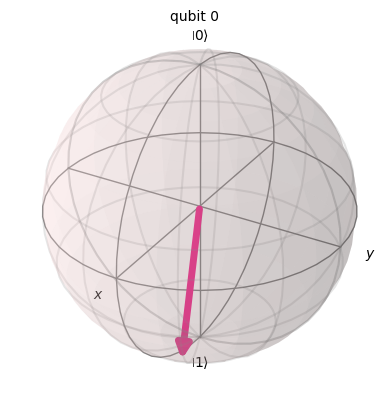

C:\Users\Equipo\AppData\Local\Temp\ipykernel_13100\628251352.py:68: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.x(qr_bob[0]).c_if(crx, 1)
C:\Users\Equipo\AppData\Local\Temp\ipykernel_13100\628251352.py:69: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.z(qr_bob[0]).c_if(crz, 1)


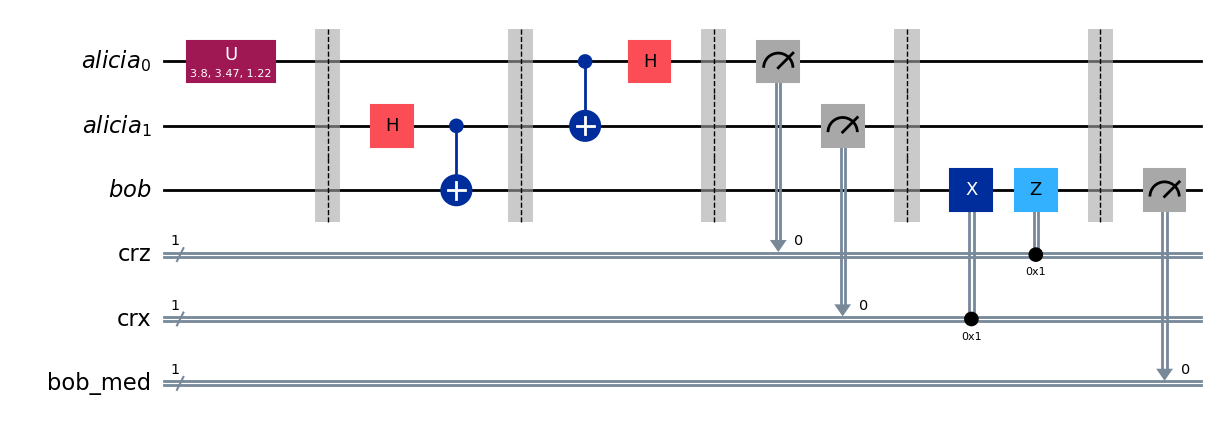

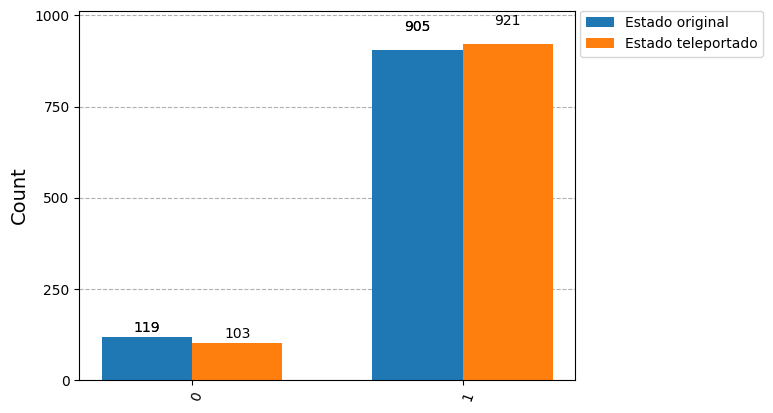

In [2]:
# generamos 3 ángulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, bell_state='phi_plus')

## $\phi^-$

<IPython.core.display.Latex object>

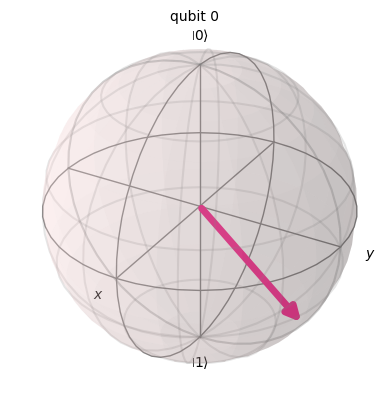

C:\Users\Equipo\AppData\Local\Temp\ipykernel_13100\628251352.py:68: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.x(qr_bob[0]).c_if(crx, 1)
C:\Users\Equipo\AppData\Local\Temp\ipykernel_13100\628251352.py:69: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.z(qr_bob[0]).c_if(crz, 1)


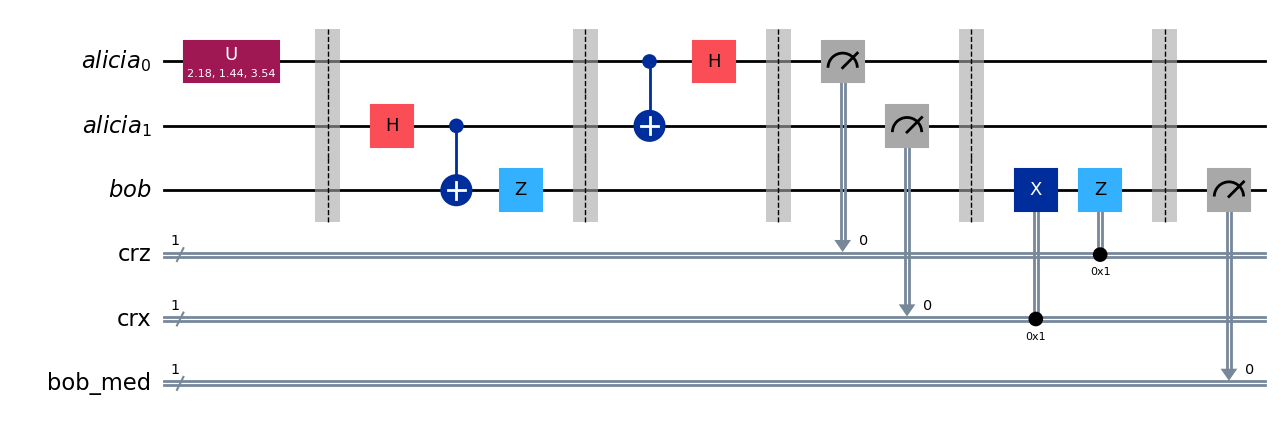

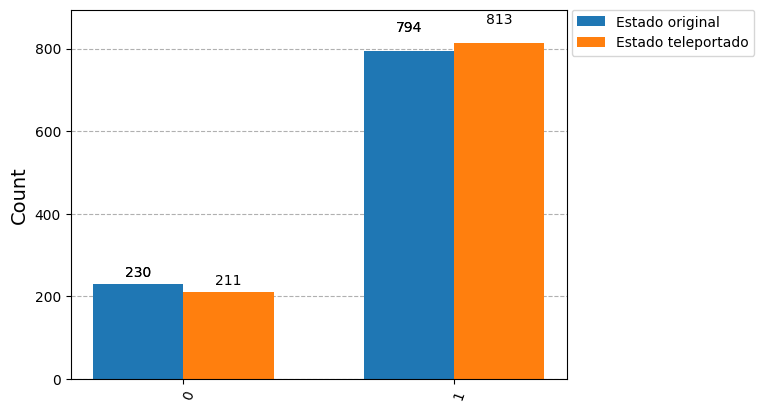

In [3]:
# generamos 3 ángulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, bell_state='phi_minus')

## $\psi^+$

<IPython.core.display.Latex object>

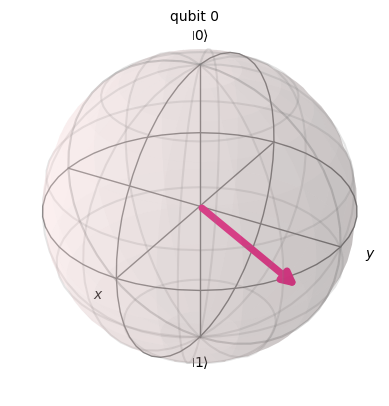

C:\Users\Equipo\AppData\Local\Temp\ipykernel_13100\628251352.py:68: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.x(qr_bob[0]).c_if(crx, 1)
C:\Users\Equipo\AppData\Local\Temp\ipykernel_13100\628251352.py:69: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.z(qr_bob[0]).c_if(crz, 1)


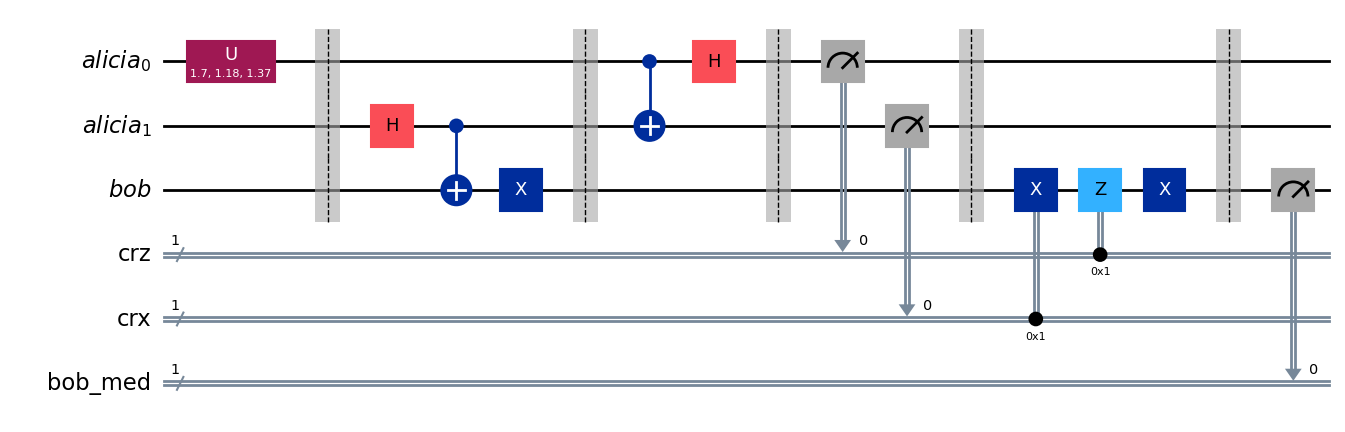

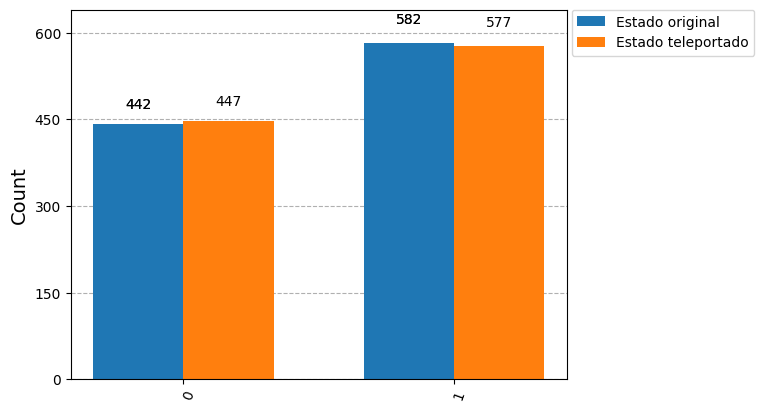

In [4]:
# generamos 3 ángulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, bell_state='psi_plus')

## $\psi^-$

<IPython.core.display.Latex object>

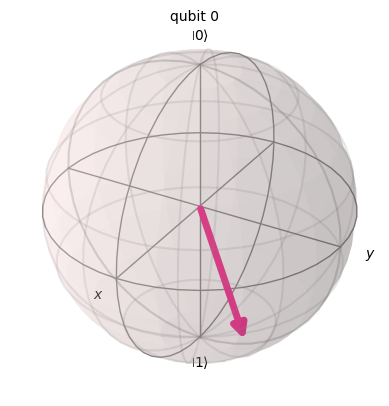

C:\Users\Equipo\AppData\Local\Temp\ipykernel_16544\628251352.py:68: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.x(qr_bob[0]).c_if(crx, 1)
C:\Users\Equipo\AppData\Local\Temp\ipykernel_16544\628251352.py:69: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circuito.z(qr_bob[0]).c_if(crz, 1)


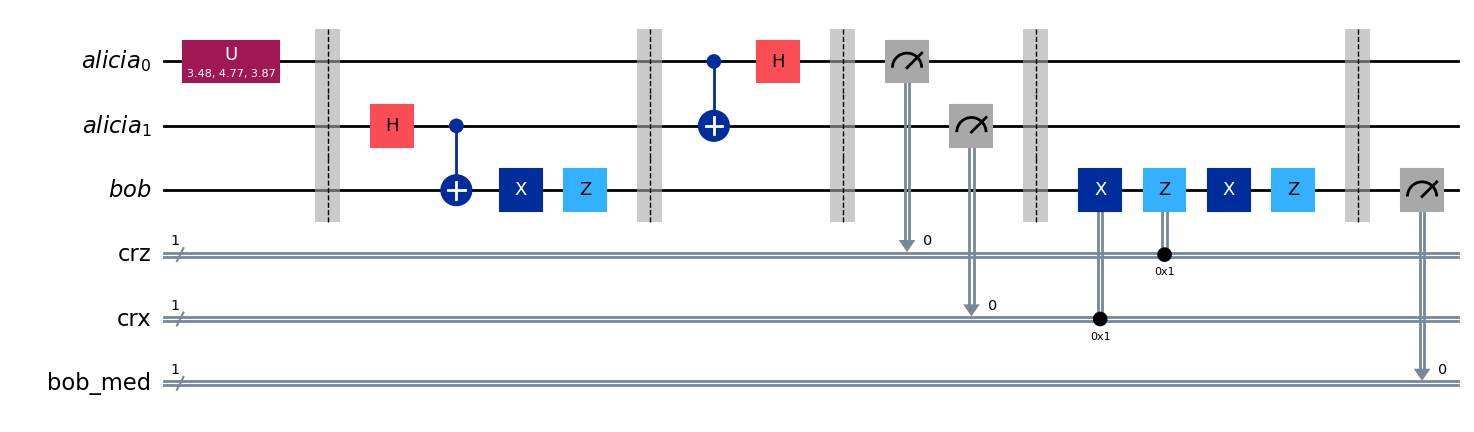

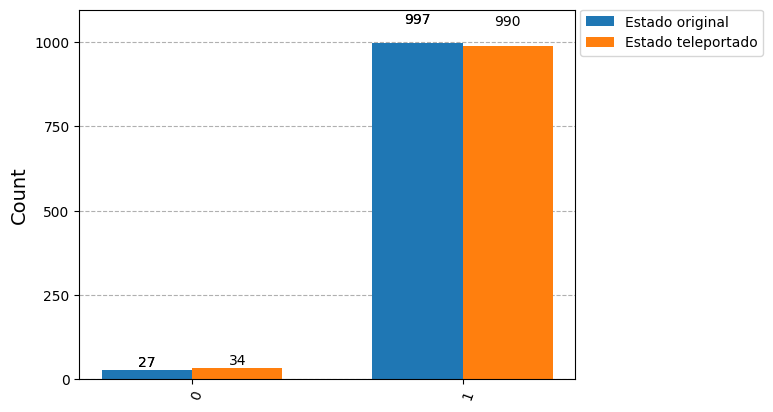

In [13]:
# generamos 3 ángulos al azar
theta = random.random() * 2 * pi
phi = random.random() * 2 * pi
lam = random.random() * 2 * pi

teleportacion(theta, phi, lam, bell_state='psi_minus')

# Ejercicio 2


Resultados de la medición:
{'10': 1000}


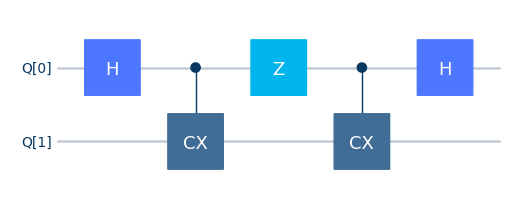

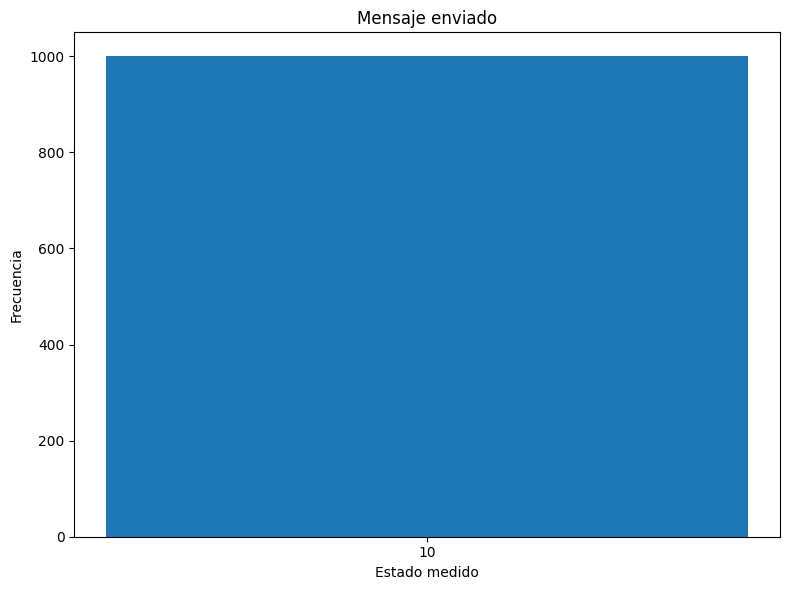

In [1]:
from spinqit import Circuit
from spinqit import H, X, Z, CX
from spinqit import get_basic_simulator, get_compiler, BasicSimulatorConfig
from spinqit import draw
import matplotlib.pyplot as plt

    # NÓTESE QUE SE INVIRTIÓ LA ASIGNACIÓN DE CUBITS RESPECTO A LA IMPLEMENTACIÓN EN QISKIT
    # YA QUE DE LO CONTRARIO, EL RESULTADO MEDIDO APARECE AL REVÉS

def crear_par_de_bell():
    # Crear circuito para par de Bell
    qc = Circuit()

    # Asignar 2 qubits (q[0] para Alicia, q[1] para Bob)
    
    q = qc.allocateQubits(2)
    # Aplicar compuerta Hadamard al qubit de Alicia (q[0])
    qc << (H, q[0])
    # Aplicar CNOT con control en Alicia (q[0]) y target en Bob (q[1])
    qc << (CX, (q[0], q[1]))
    return qc, q

def codificar_mensaje(qc, qubit, msg):
    if len(msg) != 2 or not set(msg).issubset({"0", "1"}):
        raise ValueError(f"El mensaje '{msg}' es inválido")
    if msg[1] == "1":  # es '1' el de más a la derecha en el mensaje
        qc << (X, qubit)
    if msg[0] == "1":  # es '1' el de más a la izquierda en el mensaje
        qc << (Z, qubit)
    return qc

def decodificar_mensaje(qc, q):
    qc << (CX, (q[0], q[1]))
    qc << (H, q[0])
    return qc

# ----- El protocolo completo ----- 

# Carlos crea un par entrelazado entre Alicia y Bob
qc, q = crear_par_de_bell()

# Luego, Alicia codifica su mensaje en el qubit 0 (Alicia)
mensaje = '10'    #   <---------------------------------------------------------       Modificar  aquí para hacer pruebas
qc = codificar_mensaje(qc, q[0], mensaje)

# Después de recibir el qubit 1, Bob aplica el protocolo de recuperación:
qc = decodificar_mensaje(qc, q)

# Compilar para dibujar
comp = get_compiler()
engine = get_basic_simulator()
exe = comp.compile(qc, 0)

# Visualizar el circuito
draw(exe)

# Configurar y ejecutar la simulación
config = BasicSimulatorConfig()
config.configure_shots(1000)  # Usar 1000 shots
result = engine.execute(exe, config)

# Obtener y mostrar los resultados
print("\nResultados de la medición:")
print(result.counts)

# Visualizar los resultados como histograma
plt.figure(figsize=(8, 6))
plt.bar(result.counts.keys(), result.counts.values())
plt.title("Mensaje enviado")
plt.xlabel("Estado medido")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Esta es la versión "original" con el `q[0]` para Bob y `q[1]` para Alicia. Los intercambio por que de verdad me confunde el que usen diferentes notaciones (y  de no hacerlo se nota en el histograma).  
Literalmente solo intercambié los indices  de `q[]` en el código


Resultados de la medición:
{'01': 1000}


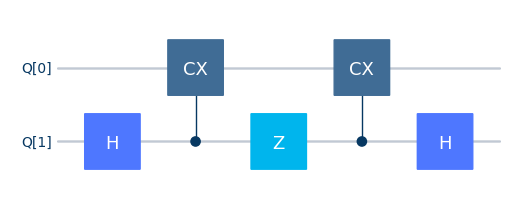

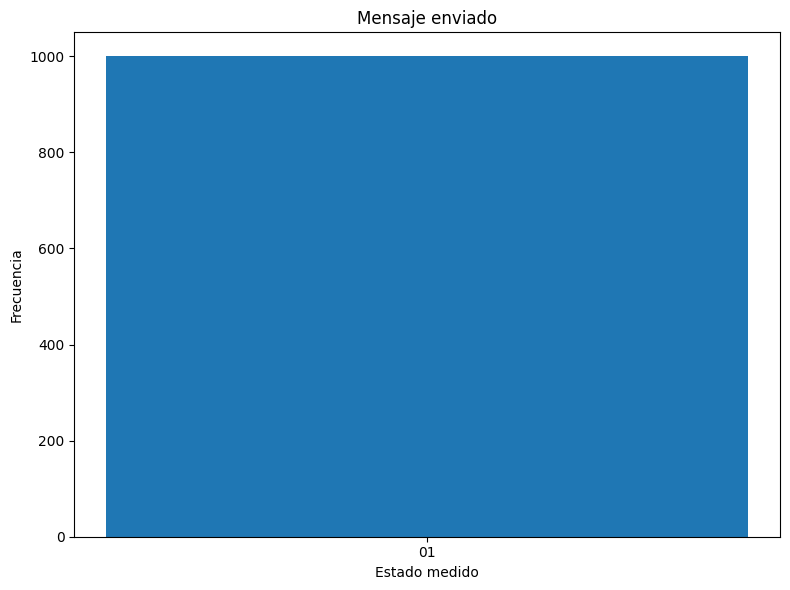

In [2]:
# from spinqit import Circuit
# from spinqit import H, X, Z, CX
# from spinqit import get_basic_simulator, get_compiler, BasicSimulatorConfig
# from spinqit import draw
# from spinqit.utils import print_circuit
# import matplotlib.pyplot as plt

# def crear_par_de_bell():
#     # Crear circuito para par de Bell
#     qc = Circuit()
#     # Asignar 2 qubits (0 para Bob, 1 para Alicia)
#     q = qc.allocateQubits(2)
#     # Aplicar compuerta Hadamard al qubit de Alicia (q[1])
#     qc << (H, q[1])
#     # Aplicar CNOT con control en Alicia (q[1]) y target en Bob (q[0])
#     qc << (CX, (q[1], q[0]))
#     return qc, q

# def codificar_mensaje(qc, qubit, msg):
#     if len(msg) != 2 or not set(msg).issubset({"0", "1"}):
#         raise ValueError(f"El mensaje '{msg}' es inválido")
#     if msg[1] == "1":  # es '1' el de más a la derecha en el mensaje
#         qc << (X, qubit)
#     if msg[0] == "1":  # es '1' el de más a la izquierda en el mensaje
#         qc << (Z, qubit)
#     return qc

# def decodificar_mensaje(qc, q):
#     qc << (CX, (q[1], q[0]))
#     qc << (H, q[1])
#     return qc

# # El protocolo completo

# # Carlos crea un par entrelazado entre Alicia y Bob
# qc, q = crear_par_de_bell()

# # Luego, Alicia codifica su mensaje en el qubit 1
# mensaje = '10'
# qc = codificar_mensaje(qc, q[1], mensaje)

# # Después de recibir el qubit 1, Bob aplica el protocolo de recuperación:
# qc = decodificar_mensaje(qc, q)

# # Compilar para dibujar
# comp = get_compiler()
# engine = get_basic_simulator()
# exe = comp.compile(qc, 0)

# # Visualizar el circuito
# draw(exe)

# # Configurar y ejecutar la simulación
# config = BasicSimulatorConfig()
# config.configure_shots(1000)  # Usar 1000 shots
# result = engine.execute(exe, config)

# # Obtener y mostrar los resultados
# print("\nResultados de la medición:")
# print(result.counts)

# # Visualizar los resultados como histograma
# plt.figure(figsize=(8, 6))
# plt.bar(result.counts.keys(), result.counts.values())
# plt.title("Mensaje enviado")
# plt.xlabel("Estado medido")
# plt.ylabel("Frecuencia")
# plt.tight_layout()
# plt.show()